In [1]:
import numpy as np
from scipy.linalg import polar, sqrtm
from matplotlib import pyplot as plt
from ncon import ncon
import sympy as sp
from sympy.physics.quantum.dagger import Dagger
from qiskit.quantum_info import Statevector

plt.rcParams['pcolor.shading'] = "auto"
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

In [2]:
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
z = np.arange(-10, 10, 0.1)
X, Y, Z = np.meshgrid(x, y, z)

In [3]:
def rnd(*x):
    return np.random.randn(*x) + 1j*np.random.randn(*x)

def SU3(x1, x2, x3, y1, y2, y3, z1, z2, z3):
    t1, t2, t3, p1, p2, p3, l1, l2, l3 = sp.symbols("t1 t2 t3 p1 p2 p3 l1 l2 l3")
    a1 = sp.Matrix([[sp.exp(p1*sp.I)*sp.cos(t1), -sp.exp(-l1*sp.I)*sp.sin(t1)], 
                    [sp.exp(sp.I*l1)*sp.sin(t1), sp.exp(-sp.I*p1)*sp.cos(t1)]])
    a2 = sp.Matrix([[sp.exp(p2*sp.I)*sp.cos(t2), -sp.exp(-l2*sp.I)*sp.sin(t2)], 
                    [sp.exp(sp.I*l2)*sp.sin(t2), sp.exp(-sp.I*p2)*sp.cos(t2)]])
    a3 = sp.Matrix([[sp.exp(p3*sp.I)*sp.cos(t3), -sp.exp(-l3*sp.I)*sp.sin(t3)], 
                    [sp.exp(sp.I*l3)*sp.sin(t3), sp.exp(-sp.I*p3)*sp.cos(t3)]])
    f = sp.lambdify((t1,t2,t3,p1,p2,p3,l1,l2,l3), a1*a2*a3, modules='numpy')
    return f(x1, x2, x3,y1, y2, y3,z1, z2, z3)

def SU(t, p, l):
    """return np.array([[np.cos(t), -np.exp(1j*l)*np.sin(t)], 
                    [np.exp(1j*p)*np.sin(t), np.exp(1j*(p+l))*np.cos(t)]])"""
    """return np.array([[np.cos(t), -np.sin(t)], 
                    [np.sin(t), np.cos(t)]])"""
    a = np.array([[np.exp(p*1j)*np.cos(t), -np.exp(-l*1j)*np.sin(t)], 
                    [np.exp(1j*l)*np.sin(t), np.exp(-1j*p)*np.cos(t)]])
    return a

def e1a1e2a2(x,y,z,a,b,c):
    t, p, l = sp.symbols("t p l")
    s, q, k = sp.symbols("s q k")
    a1 = sp.Matrix([[sp.exp(p*sp.I)*sp.cos(t), -sp.exp(-l*sp.I)*sp.sin(t)], 
                    [sp.exp(sp.I*l)*sp.sin(t), sp.exp(-sp.I*p)*sp.cos(t)]])
    a2 = sp.Matrix([[sp.exp(q*sp.I)*sp.cos(s), -sp.exp(-k*sp.I)*sp.sin(s)], 
                    [sp.exp(sp.I*k)*sp.sin(s), sp.exp(-sp.I*q)*sp.cos(s)]])
    f = sp.lambdify((t,p,l,s,q,k), E1*a1*E2*a2, modules='numpy')
    return f(x,y,z,a,b,c)

def e1ae2a2(x,y,z):
    t, p, l = sp.symbols("t p l")
    a = sp.Matrix([[sp.exp(p*sp.I)*sp.cos(t), -sp.exp(-l*sp.I)*sp.sin(t)], 
                    [sp.exp(sp.I*l)*sp.sin(t), sp.exp(-sp.I*p)*sp.cos(t)]])
    f = sp.lambdify((t,p,l), sp.Trace(E1*Dagger(a)*E2*a).simplify()*sp.Trace(Dagger(E1*Dagger(a)*E2*a)).simplify(), modules='numpy')
    return f(x,y,z)

def patma2(x,y,z):
    t, p, l = sp.symbols("t p l")
    a = sp.Matrix([[sp.exp(p*sp.I)*sp.cos(t), -sp.exp(-l*sp.I)*sp.sin(t)], 
                    [sp.exp(sp.I*l)*sp.sin(t), sp.exp(-sp.I*p)*sp.cos(t)]])
    f = sp.lambdify((t,p,l), sp.Trace(P*Dagger(a)*M*a).simplify()*sp.Trace(Dagger(P*Dagger(a)*M*a)).simplify(), modules='numpy')
    return f(x,y,z)

In [5]:
E1 = np.random.randn(2, 2) + 1j*np.random.randn(2, 2)
E2 = np.random.randn(2, 2) + 1j*np.random.randn(2, 2)

In [41]:
print(e1ae2a2(X,Y,Z).max())

(46.796984322646004+1.7763568394002505e-14j)


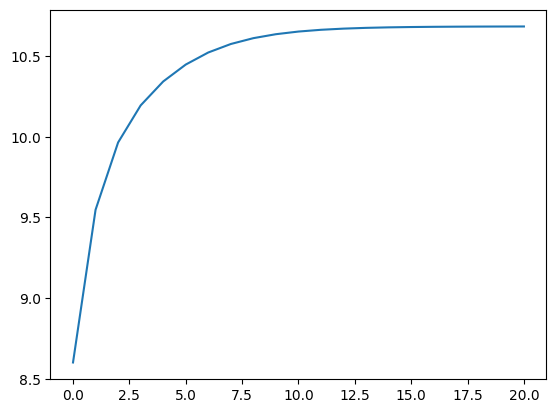

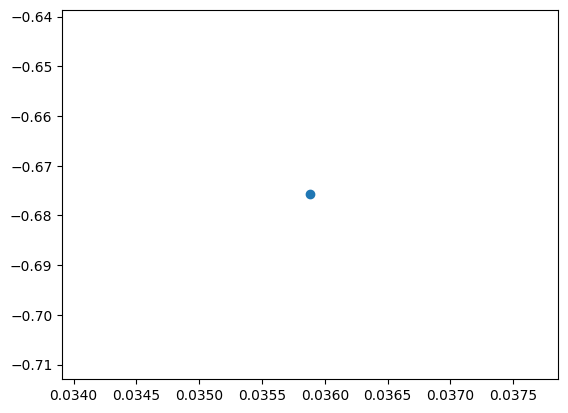

In [19]:
Us = []
for _ in range(2000):
    U = polar(np.random.randn(2, 2) + 1j*np.random.randn(2, 2))[0] 

    tr = []

    tr.append(ncon([E1, U.T.conj(), E2, U], [[1,2], [2,3], [3,4], [4,1]])*ncon([E1.T.conj(), U.T.conj(), E2.T.conj(), U], [[1,2], [2,3], [3,4], [4,1]]))
    for _ in range(20):
        d1 = ncon([E1.T.conj(), E2.T.conj(), U], [[1,-2], [-1,4], [4,1]])*ncon([E1, U.T.conj(), E2, U], [[1,2], [2,3], [3,4], [4,1]])
        d2 = ncon([E1, E2, U], [[1,-2], [-1,4], [4,1]])*ncon([E1.T.conj(), U.T.conj(), E2.T.conj(), U], [[1,2], [2,3], [3,4], [4,1]])
        U = polar(d1 + d2)[0]
        tr.append(ncon([E1, U.T.conj(), E2, U], [[1,2], [2,3], [3,4], [4,1]])*ncon([E1.T.conj(), U.T.conj(), E2.T.conj(), U], [[1,2], [2,3], [3,4], [4,1]]))

    Us.append(U)
    break

fig = plt.figure()
#plt.axhline(y=e1ae2a2(X,Y,Z).max(), color='r', linestyle='--')
plt.plot(tr)

Us = np.array(Us)

fig = plt.figure()
plt.scatter(Us[:,0,0], Us[:,1 ,1])

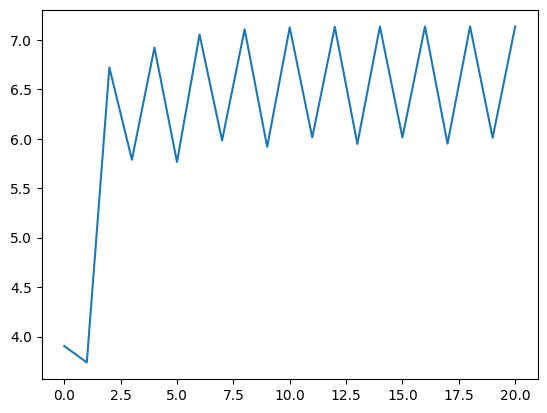

In [28]:
# a)
M = np.random.randn(8, 8) + 1j*np.random.randn(8, 8) + (np.random.randn(8, 8) + 1j*np.random.randn(8, 8)).T.conj()
U1 = np.eye(4) # np.random.randn(4,2) + 1j*np.random.randn(4,2)
U2 = np.eye(4) # np.random.randn(2,2) + 1j*np.random.randn(2,2)
tr = []

tr.append(np.abs(ncon([np.array([1,0,0,0,0,0,0,0]), M.reshape(8,4,2), U1.reshape(4,2,2), np.array([1,0]), U2.reshape(2,2,4), np.array([1,0,0,0])], [[4], [4,1,2], [1,3,5], [5], [3,2,6], [6]])))
for _ in range(10):
    u = polar(ncon([np.array([1,0,0,0,0,0,0,0]), M.reshape(8,4,2), U1.reshape(4,2,2), np.array([1,0]), np.array([1,0,0,0])], [[4], [4,1,-2], [1,-3,5], [5], [-6]]).reshape(4,4))[0]
    U2 = u.T.conj()
    tr.append(np.abs(ncon([np.array([1,0,0,0,0,0,0,0]), M.reshape(8,4,2), U1.reshape(4,2,2), np.array([1,0]), U2.reshape(2,2,4), np.array([1,0,0,0])], [[4], [4,1,2], [1,3,5], [5], [3,2,6], [6]])))

    u = polar(ncon([np.array([1,0,0,0,0,0,0,0]), M.reshape(8,4,2), np.array([1,0]), U2.reshape(2,2,4), np.array([1,0,0,0])], [[4], [4,-3,2], [-2], [-1,2,6], [6]]).reshape(4,4))[0]
    U1 = u.T.conj()
    tr.append(np.abs(ncon([np.array([1,0,0,0,0,0,0,0]), M.reshape(8,4,2), U1.reshape(4,2,2), np.array([1,0]), U2.reshape(2,2,4), np.array([1,0,0,0])], [[4], [4,1,2], [1,3,5], [5], [3,2,6], [6]])))

fig = plt.figure()
plt.plot(tr)

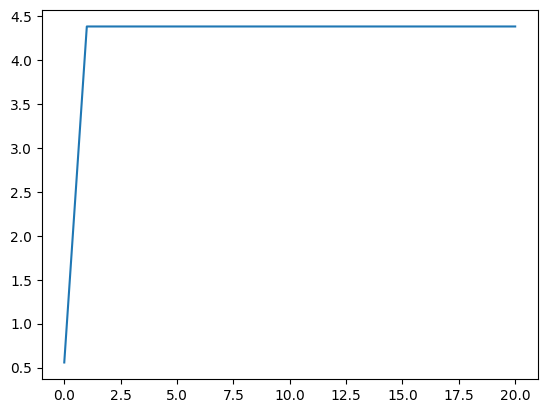

In [33]:
M = np.random.randn(8, 8) + 1j*np.random.randn(8, 8)
U3 = np.eye(8) # np.random.randn(8, 8) + 1j*np.random.randn(8, 8)
P = np.outer(np.array([1,0,0,0,0,0,0,0]), np.array([1,0,0,0,0,0,0,0]))
tr = []

tr.append(np.abs(ncon([M, U3, P], [[1,2], [2,3], [3,1]])))
for _ in range(20):
    u = polar(ncon([P, M], [[-1,2], [2,-3]]), side="left")[0]
    U3 = u.T.conj()
    tr.append(np.abs(ncon([M, U3, P], [[1,2], [2,3], [3,1]])))
    assert np.allclose(ncon([P, M], [[-1,2], [2,-3]]), ncon([M, P], [[1,-2], [-1,1]]))

fig = plt.figure()
plt.plot(tr)

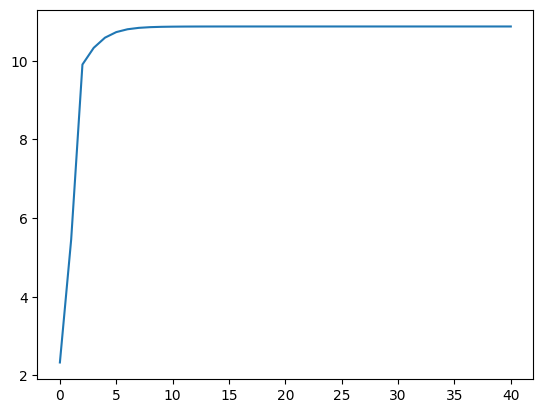

In [38]:
# b)
M = np.random.randn(4,8) + 1j*np.random.randn(4,8)
U1 = np.eye(8,2) # np.random.randn(8, 2) + 1j*np.random.randn(8, 2)
U2 = np.eye(2,4) # np.random.randn(2,4) + 1j*np.random.randn(2,4)
tr = []

tr.append(np.abs(ncon([M, U1, U2], [[1,2], [2,3], [3,1]])))
for _ in range(20):
    u = polar(ncon([M, U1], [[-1,1], [1,-2]]), side="left")[0]
    U2 = u.T.conj()
    tr.append(np.abs(ncon([M, U1, U2], [[1,2], [2,3], [3,1]])))

    u = polar(ncon([M, U2], [[1,-2], [-1,1]]), side="left")[0]
    U1 = u.T.conj()
    tr.append(np.abs(ncon([M, U1, U2], [[1,2], [2,3], [3,1]])))

fig = plt.figure()
plt.plot(tr)

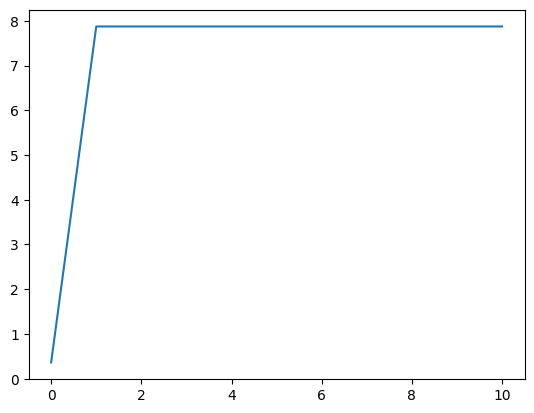

In [41]:
M = np.random.randn(32, 32) + 1j*np.random.randn(32, 32)
U5 = np.eye(32) # np.random.randn(32,32) + 1j*np.random.randn(32,32)
P = np.outer(Statevector.from_label("00000"), Statevector.from_label("00000"))
tr = []

tr.append(np.abs(ncon([P, M, U5], [[1,2], [2,3], [3,1]])))
for _ in range(10):
    u, p = polar(ncon([P, M], [[-1,2], [2,-3]]), side="left")
    U5 = u.T.conj()
    tr.append(np.abs(ncon([P, M, U5], [[1,2], [2,3], [3,1]])))

fig = plt.figure()
plt.plot(tr)

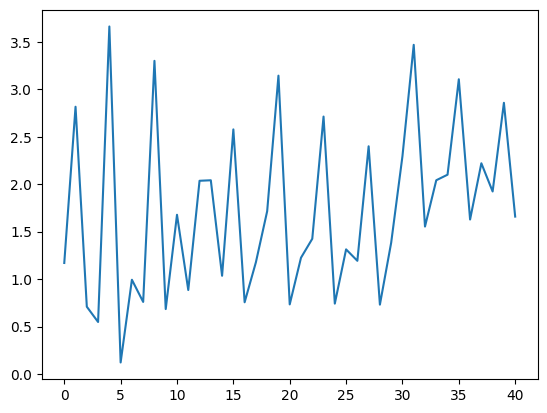

In [54]:
# c)
M = np.random.randn(2,2,2,2) + 1j*np.random.randn(2,2,2,2)
U1 = np.eye(2) # np.random.randn(2,2) + 1j*np.random.randn(2,2)
U2 = np.eye(2) # np.random.randn(2,2) + 1j*np.random.randn(2,2)
P = np.outer(np.array([1,0]), np.array([1,0]))
M = ncon([np.array([1,0]), M, np.array([1,0])], [[1], [1,2,-3,-4], [2]])
tr = []

#tr.append(np.abs(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])))
tr.append(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])*ncon([U2.T.conj(), M.T.conj(), U1.T.conj(), P], [[1,2], [2,3], [3,4], [4,1]]))
for _ in range(20):
#while not np.allclose(np.linalg.svd(M)[1][0], np.abs(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]]))):
    U2 = polar(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])*ncon([M.T.conj(), U1.T.conj(), P], [[-2,3], [3,4], [4,-1]]))[0]
    #tr.append(np.abs(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])))
    tr.append(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])*ncon([U2.T.conj(), M.T.conj(), U1.T.conj(), P], [[1,2], [2,3], [3,4], [4,1]]))

    U1 = polar(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])*ncon([U2.T.conj(), M.T.conj(), P], [[1,2], [2,-3], [-4,1]]))[0]
    #tr.append(np.abs(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])))
    tr.append(ncon([P, U1, M, U2], [[1,2], [2,3], [3,4], [4,1]])*ncon([U2.T.conj(), M.T.conj(), U1.T.conj(), P], [[1,2], [2,3], [3,4], [4,1]]))

fig = plt.figure()
plt.plot(tr)
#plt.axhline(y=np.linalg.svd(M)[1][0]**2, c="red", linestyle="--")

(4.009521470956655+0j)


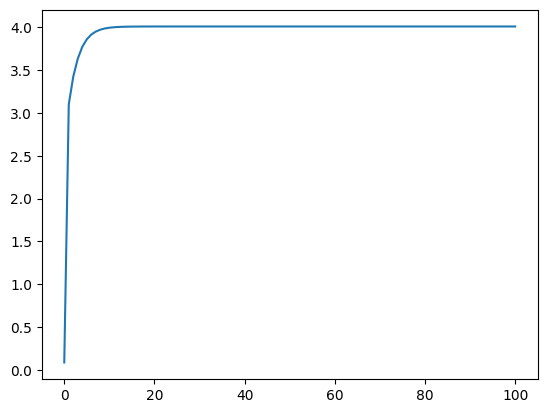

In [62]:
# d)
eps = 0.1
M = np.random.randn(2,2) + 1j*np.random.randn(2,2)
M = M + M.T.conj() + eps*(M - M.T.conj())
U = np.identity(2, dtype = "complex128")
U2 = np.identity(2, dtype = "complex128")
P = np.outer(np.array([1,0]), np.array([1,0]))
tr = []

#tr.append(np.abs(ncon([P, U.T.conj(), M, U], [[1,2], [2,3], [3,4], [4,1]])))
tr.append(ncon([P, U.T.conj(), M, U], [[1,2], [2,3], [3,4], [4,1]])*ncon([P, U.T.conj(), M.T.conj(), U], [[1,2], [2,3], [3,4], [4,1]]))
#while not np.allclose(np.linalg.svd(M)[1][0], np.abs(ncon([P, U.T.conj(), M, U], [[1,2], [2,3], [3,4], [4,1]]))):
for _ in range(100):
    #U = polar(ncon([P, U.T.conj(), M], [[-1,2], [2,3], [3,-4]]).T.conj(), side="left")[0]
    #U = polar(ncon([P, M, U], [[1,-2], [-1,4], [4,1]]), side="left")[0]
    dC1 = ncon([P, U.T.conj(), M, U], [[1,2], [2,3], [3,4], [4,1]])*ncon([P, M.T.conj(), U], [[1,-2], [-1,4], [4,1]])
    dC2 = ncon([P, U.T.conj(), M.T.conj(), U], [[1,2], [2,3], [3,4], [4,1]])*ncon([P, M, U], [[1,-2], [-1,4], [4,1]])
    U = polar(dC1 + dC2, side="left")[0]
    #tr.append(np.abs(ncon([P, U.T.conj(), M, U], [[1,2], [2,3], [3,4], [4,1]])))
    tr.append(ncon([P, U.T.conj(), M, U], [[1,2], [2,3], [3,4], [4,1]])*ncon([P, U.T.conj(), M.T.conj(), U], [[1,2], [2,3], [3,4], [4,1]]))

"""fig = plt.figure()
plt.pcolormesh(x, y, np.abs(np.trace(SUn(X,Y,Z)))[:,:,99])
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\phi$")
cbar = plt.colorbar()
cbar.set_label(r"$tr(EUU(\theta, \phi, \lambda))$")"""

fig = plt.figure()
plt.plot(tr)
#plt.axhline(y=np.linalg.svd(M)[1][0]**2, c="red", linestyle="--")
#plt.axhline(y=patma2(X,Y,Z).max(), color='r', linestyle='--')
#print(np.linalg.svd(M)[1][0]**2)
#print(patma2(X,Y,Z).max())
print(tr[-1])

(0.03905740323388142+0j)


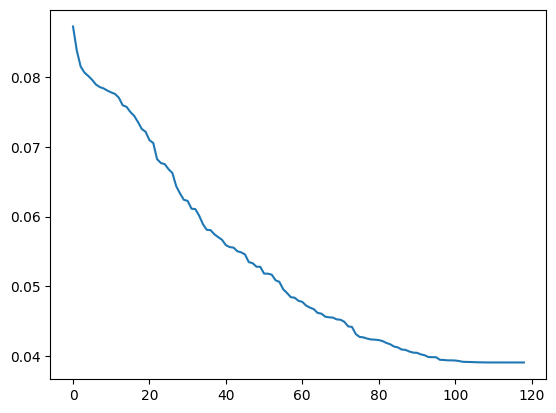

In [63]:
# Stochastic minimization
tr = []
eps = 0.01
for _ in range(200):
    for __ in range(20):
        Unext = polar(U2 + eps*rnd(*U2.shape))[0]
        if ncon([P, U2.T.conj(), M, U2], [[1,2], [2,3], [3,4], [4,1]])*ncon([P, U2.T.conj(), M.T.conj(), U2], [[1,2], [2,3], [3,4], [4,1]]) > ncon([P, Unext.T.conj(), M, Unext], [[1,2], [2,3], [3,4], [4,1]])*ncon([P, Unext.T.conj(), M.T.conj(), Unext], [[1,2], [2,3], [3,4], [4,1]]):
            U2 = Unext
            tr.append(ncon([P, U2.T.conj(), M, U2], [[1,2], [2,3], [3,4], [4,1]])*ncon([P, U2.T.conj(), M.T.conj(), U2], [[1,2], [2,3], [3,4], [4,1]]))

fig = plt.figure()
plt.plot(tr)
print(tr[-1])